# A Different Moneyball

* By: Matthew Cohen
* (Based on the concept of the movie Moneyball)
* Hypothesis: Can wins in the NBA be predicted by statistics other than those that are shown on the scoreboard? In other words, disregarding points, can a teams success over a season be accurately predicted?
* 
* 

## Bringing in Data and Necessary Packages

In [2]:
import sqlite3
import pandas
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn import ensemble
import numpy
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import  GridSearchCV
from sklearn import tree
import matplotlib.pyplot as plt

%matplotlib inline

conn = sqlite3.connect('/Users/MatthewCohen/Documents/SQLite/TeamSeason1.sqlite')
query = """SELECT t.won as wins, g.good_team, t.o_fgm as field_goals_made, t.o_fga as field_goals_attempted,
t.o_ftm as free_throws_made, t.o_fta as free_throws_attempted, t.o_oreb as offensive_rebounds,
t.o_dreb as defensive_rebounds, t.o_reb as total_rebounds, t.o_asts as assists, t.o_pf as personal_fouls,
t.o_stl as steals, t.o_to as turnovers, t.o_3pm as three_pointers_made, t.o_3pa as three_pointers_attempted,
t.d_fgm as field_goals_allowed, t.d_fga as field_goal_attempts_allowed, t.d_reb as rebounds_allowed,
t.d_asts as assists_allowed, t.d_pf as fouls_against, t.d_3pm as three_point_makes_allowed,
((o_fgm / o_fga)*100) as field_goal_percentage, ((o_ftm / o_fta)*100) as free_throw_percentage,
((o_3pm / o_3pa)*100) as three_point_percentage, o_blk as blocks, o_pts as points, d_pts as points_against
FROM TeamSeason1 t
LEFT OUTER JOIN Good_Teams2 g ON t.team = g.team and t.year = g.year
WHERE t.year > 1980 and t.year <= 2009;"""
df = pandas.read_sql(query, conn)
conn.close

<function close>

## 

## Defining Explanatory Features and Response Series

In [3]:
explanatory_features = [col for col in df.columns if col not in ['field_goals_made', 'field_goals_allowed', 'good_team', 'wins', 'points', 'points_against', 'free_throws_made', 'three_pointers_made']]
explanatory_df = df[explanatory_features]
explanatory_colnames = explanatory_df.columns

response_series = df.good_team

## Checking for Correlation Between Explanatory Variables

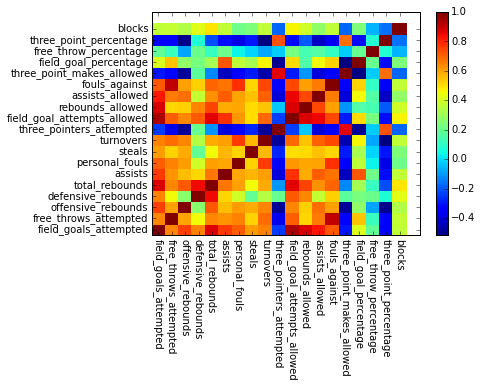

In [4]:
toChart = explanatory_df.corr()
plt.pcolor(toChart)
plt.yticks(numpy.arange(0.5, len(toChart.index), 1), toChart.index)
plt.xticks(numpy.arange(0.5, len(toChart.columns), 1), toChart.columns, rotation=-90)
plt.colorbar()
plt.show()

## Removing any Explanatory Features that are Highly Correlated

In [5]:
def find_perfect_corr(df):
    """finds columns that are eother positively or negatively perfectly correlated (with correlations of +1 or -1), and creates a dict 
        that includes which columns to drop so that each remaining column
        is independent
    """  
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  numpy.tril(corrMatrix.values, k = -1)
    already_in = set()
    result = []
    for col in corrMatrix:
        perfect_corr = corrMatrix[col][abs(numpy.round(corrMatrix[col],10)) >= 0.9].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    toRemove = []
    for item in result:
        toRemove.append(item[1:(len(item)+1)])
    toRemove = sum(toRemove, [])
    return {'corrGroupings':result, 'toRemove':toRemove}

no_correlation = find_perfect_corr(explanatory_df)
explanatory_df.drop(no_correlation['toRemove'], 1, inplace = True)
print no_correlation

{'corrGroupings': [['field_goal_attempts_allowed', 'field_goals_attempted'], ['fouls_against', 'free_throws_attempted']], 'toRemove': ['field_goals_attempted', 'free_throws_attempted']}


/Users/MatthewCohen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame


## Scaling Data

In [6]:
scaler = preprocessing.StandardScaler()
scaler.fit(explanatory_df)
explanatory_df = pandas.DataFrame(scaler.transform(explanatory_df), columns = explanatory_df.columns)

## Scanning for best # of features to use

In [7]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn import tree

class RandomForestsWithCoef(ensemble.RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(ensemble.RandomForestClassifier, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_

rfWithCoef = RandomForestsWithCoef(n_estimators= 500)
rfe_cv = RFECV(estimator=rfWithCoef, step=1, cv=10, scoring='roc_auc', verbose = 0)
rfe_cv.fit(explanatory_df, response_series)

RFECV(cv=10,
   estimator=RandomForestsWithCoef(bootstrap=True, compute_importances=None,
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0),
   estimator_params={}, loss_func=None, scoring='roc_auc', step=1,
   verbose=0)

## Defining New Feature Set

In [8]:
explanatory_features = [col for col in df.columns if col not in ['field_goals_made', 'field_goals_allowed', 'good_team', 'wins', 'points', 'points_against', 'free_throws_made', 'three_pointers_made', 'offensive_rebounds']]
explanatory_df = df[explanatory_features]
explanatory_colnames = explanatory_df.columns

# Predicting Wins Using Random Forests

In [9]:
rf = ensemble.RandomForestClassifier(n_estimators= 500)
roc_scores_rf = cross_val_score(rf, explanatory_df, response_series, cv=10, scoring='roc_auc', n_jobs = -1)
print roc_scores_rf.mean()

0.903573327258


## Grid Search for Best Parameters

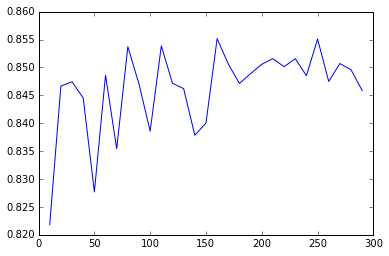

In [21]:
trees_range = range(10, 300, 10)
param_grid = dict(n_estimators = trees_range)
grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc', n_jobs = -1)
grid.fit(explanatory_df, response_series)
grid_mean_scores = [result[1] for result in grid.grid_scores_]
plt.figure()
plt.plot(trees_range, grid_mean_scores)

## Displaying Best Score

In [22]:
best_rf_est = grid.best_estimator_
print best_rf_est.n_estimators
print grid.best_score_

160
0.855148875761


## Plotting Sensitivity vs Specificity

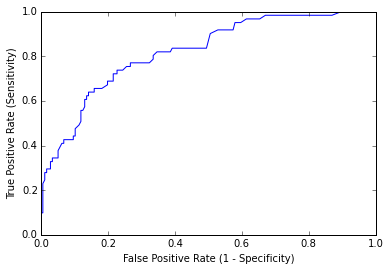

In [23]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

xTrain, xTest, yTrain, yTest = train_test_split(
                    explanatory_df, response_series, test_size =  0.3)
rf_probabilities = pandas.DataFrame(best_rf_est.fit(xTrain, yTrain).predict_proba(xTest))
rf_fpr, rf_tpr, thresholds = metrics.roc_curve(yTest, rf_probabilities[1])

plt.figure()
plt.plot(rf_fpr, rf_tpr, color = 'b')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

## Predict on the New Data

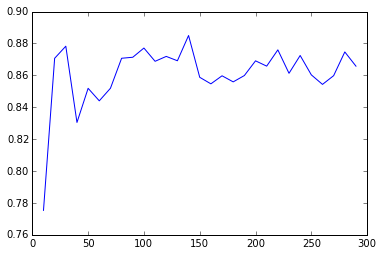

In [24]:
# Making two different groups - TRAINING and HOLDOUT
# TRAINING
conn = sqlite3.connect('/Users/MatthewCohen/Documents/SQLite/TeamSeason1.sqlite')
query = """SELECT t.won as wins, g.good_team, t.o_fgm as field_goals_made, t.o_fga as field_goals_attempted,
t.o_ftm as free_throws_made, t.o_fta as free_throws_attempted, t.o_oreb as offensive_rebounds,
t.o_dreb as defensive_rebounds, t.o_reb as total_rebounds, t.o_asts as assists, t.o_pf as personal_fouls,
t.o_stl as steals, t.o_to as turnovers, t.o_3pm as three_pointers_made, t.o_3pa as three_pointers_attempted,
t.d_fgm as field_goals_allowed, t.d_fga as field_goal_attempts_allowed, t.d_reb as rebounds_allowed,
t.d_asts as assists_allowed, t.d_pf as fouls_against, t.d_3pm as three_point_makes_allowed,
((o_fgm / o_fga)*100) as field_goal_percentage, ((o_ftm / o_fta)*100) as free_throw_percentage,
((o_3pm / o_3pa)*100) as three_point_percentage, o_blk as blocks, o_pts as points, d_pts as points_against
FROM TeamSeason1 t
LEFT OUTER JOIN Good_Teams2 g ON t.team = g.team and t.year = g.year
WHERE t.year > 1980 and t.year < 1999;"""
df = pandas.read_sql(query, conn)
conn.close

# Defining Explanatory Features
#'field_goals_made', 'field_goals_allowed', 'good_team', 'wins', 'points', 'points_against', 'free_throws_made', 'three_pointers_made'
explanatory_features = [col for col in df.columns if col not in ['field_goals_made', 'field_goals_allowed', 'good_team', 'wins', 'points', 'points_against', 'free_throws_made', 'three_pointers_made', 'offensive_rebounds']]
explanatory_df = df[explanatory_features]
explanatory_colnames = explanatory_df.columns

# Defining Response Series
response_series = df.good_team

# Scaling data such that it is normally distributed in order to input into model and improve accuracy
scaler = preprocessing.StandardScaler()
scaler.fit(explanatory_df)
explanatory_df = pandas.DataFrame(scaler.transform(explanatory_df), columns = explanatory_df.columns)

# Predicting wins using Random Forests 
rf = ensemble.RandomForestClassifier(n_estimators= 500)
roc_scores_rf = cross_val_score(rf, explanatory_df, response_series, cv=10, scoring='roc_auc', n_jobs = -1)

# Grid Search for best parameters
trees_range = range(10, 300, 10)
param_grid = dict(n_estimators = trees_range)
grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc', n_jobs = -1)
grid.fit(explanatory_df, response_series)
grid_mean_scores = [result[1] for result in grid.grid_scores_]
plt.figure()
plt.plot(trees_range, grid_mean_scores)


best_rf_est = grid.best_estimator_


# HOLDOUT
conn = sqlite3.connect('/Users/MatthewCohen/Documents/SQLite/TeamSeason1.sqlite')
query2 = """SELECT t.won as wins, g.good_team, t.o_fgm as field_goals_made, t.o_fga as field_goals_attempted,
t.o_ftm as free_throws_made, t.o_fta as free_throws_attempted, t.o_oreb as offensive_rebounds,
t.o_dreb as defensive_rebounds, t.o_reb as total_rebounds, t.o_asts as assists, t.o_pf as personal_fouls,
t.o_stl as steals, t.o_to as turnovers, t.o_3pm as three_pointers_made, t.o_3pa as three_pointers_attempted,
t.d_fgm as field_goals_allowed, t.d_fga as field_goal_attempts_allowed, t.d_reb as rebounds_allowed,
t.d_asts as assists_allowed, t.d_pf as fouls_against, t.d_3pm as three_point_makes_allowed,
((o_fgm / o_fga)*100) as field_goal_percentage, ((o_ftm / o_fta)*100) as free_throw_percentage,
((o_3pm / o_3pa)*100) as three_point_percentage, o_blk as blocks, o_pts as points, d_pts as points_against
FROM TeamSeason1 t
LEFT OUTER JOIN Good_Teams2 g ON t.team = g.team and t.year = g.year
WHERE t.year >= 1999 and t.year <= 2009;"""
df2 = pandas.read_sql(query2, conn)
conn.close

# Defining Explanatory Features
#'field_goals_made', 'field_goals_allowed', 'good_team', 'wins', 'points', 'points_against"
explanatory_features2 = [col for col in df2.columns if col not in ['field_goals_made', 'field_goals_allowed', 'good_team', 'wins', 'points', 'points_against', 'free_throws_made', 'three_pointers_made', 'offensive_rebounds']]
explanatory_df2 = df2[explanatory_features2]
explanatory_colnames2 = explanatory_df2.columns

# Defining Response Series
response_series2 = df2.good_team

# Scaling data such that it is normally distributed in order to input into model and improve accuracy
scaler = preprocessing.StandardScaler()
scaler.fit(explanatory_df2)
explanatory_df2 = pandas.DataFrame(scaler.transform(explanatory_df2), columns = explanatory_df2.columns)

## Creating Prediction Object

In [25]:
prediction = best_rf_est.predict(explanatory_df2)

## Visualize Results

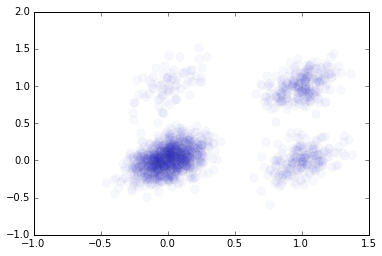

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

y = response_series2.tolist()
yhat = prediction.tolist()

def randomize(mean):
    N = 5
    cov = [[0.02, 0.02], [0, 0.02]]
    x,y = np.random.multivariate_normal(mean, cov, N).T
    plt.scatter(x, y, s=70, alpha=0.03)

for i in range(1,325):
    randomize((y[i], yhat[i]))

## Checking for Accuracy

In [27]:
diff = (response_series2 - prediction).tolist()
accuracy = (diff.count(0)/len(diff))*100
print accuracy

0


## List of feature importances

In [28]:
importances = pandas.DataFrame(grid.best_estimator_.feature_importances_, index = explanatory_df.columns, columns =['importance'])
importances.sort(columns = ['importance'], ascending = False, inplace = True)
print importances

                             importance
field_goal_percentage          0.122795
defensive_rebounds             0.108721
rebounds_allowed               0.091865
assists                        0.070202
turnovers                      0.061630
three_point_percentage         0.061299
total_rebounds                 0.051376
blocks                         0.050103
assists_allowed                0.048359
personal_fouls                 0.045823
steals                         0.045672
free_throw_percentage          0.040892
free_throws_attempted          0.038098
three_pointers_attempted       0.036026
field_goals_attempted          0.033915
three_point_makes_allowed      0.033079
field_goal_attempts_allowed    0.030997
fouls_against                  0.029148


## Recursive feature elimination

In [29]:
#rfWithCoef = RandomForestsWithCoef(n_estimators= 500)
rfe = RFE(estimator=rfWithCoef, n_features_to_select=3, step=1, verbose = 0)
rfe.fit(explanatory_df, response_series)

features_used = explanatory_df.columns[rfe.get_support()]
print features_used

Index([u'defensive_rebounds', u'rebounds_allowed', u'field_goal_percentage'], dtype='object')


## Run Random Forests on 3 Best Features

In [19]:
conn = sqlite3.connect('/Users/MatthewCohen/Documents/SQLite/TeamSeason1.sqlite')
query = """SELECT t.won as wins, g.good_team, t.o_fgm as field_goals_made, t.o_fga as field_goals_attempted,
t.o_ftm as free_throws_made, t.o_fta as free_throws_attempted, t.o_oreb as offensive_rebounds,
t.o_dreb as defensive_rebounds, t.o_reb as total_rebounds, t.o_asts as assists, t.o_pf as personal_fouls,
t.o_stl as steals, t.o_to as turnovers, t.o_3pm as three_pointers_made, t.o_3pa as three_pointers_attempted,
t.d_fgm as field_goals_allowed, t.d_fga as field_goal_attempts_allowed, t.d_reb as rebounds_allowed,
t.d_asts as assists_allowed, t.d_pf as fouls_against, t.d_3pm as three_point_makes_allowed,
((o_fgm / o_fga)*100) as field_goal_percentage, ((o_ftm / o_fta)*100) as free_throw_percentage,
((o_3pm / o_3pa)*100) as three_point_percentage, o_blk as blocks, o_pts as points, d_pts as points_against
FROM TeamSeason1 t
LEFT OUTER JOIN Good_Teams2 g ON t.team = g.team and t.year = g.year
WHERE t.year > 1980 and t.year <= 2009;"""
df = pandas.read_sql(query, conn)
conn.close

# Defining Explanatory Features
#'field_goals_made', 'field_goals_allowed', 'good_team', 'wins', 'points', 'points_against', 'free_throws_made', 'three_pointers_made'
explanatory_features = [col for col in df.columns if col in ['defensive_rebounds', 'field_goal_percentage', 'assists_allowed']]
explanatory_df = df[explanatory_features]
explanatory_colnames = explanatory_df.columns

# Defining Response Series
response_series = df.good_team

# Scaling data such that it is normally distributed in order to input into model and improve accuracy
scaler = preprocessing.StandardScaler()
scaler.fit(explanatory_df)
explanatory_df = pandas.DataFrame(scaler.transform(explanatory_df), columns = explanatory_df.columns)

## Predicting wins using Random Forests

In [20]:
rf = ensemble.RandomForestClassifier(n_estimators= 500)
roc_scores_rf = cross_val_score(rf, explanatory_df, response_series, cv=10, scoring='roc_auc', n_jobs = -1)
print roc_scores_rf.mean()

0.851648059543


## Grid Search for best parameters

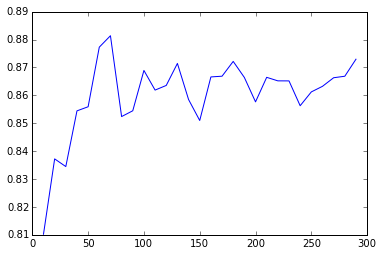

In [30]:
trees_range = range(10, 300, 10)
param_grid = dict(n_estimators = trees_range)
grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc', n_jobs = -1)
grid.fit(explanatory_df, response_series)
grid_mean_scores = [result[1] for result in grid.grid_scores_]
plt.figure()
plt.plot(trees_range, grid_mean_scores)

## Best Estimator

In [31]:
best_rf_est = grid.best_estimator_
print best_rf_est.n_estimators
print grid.best_score_

70
0.881351080039


## FINDING ACCURACY OF SUBSET OF FEATURES

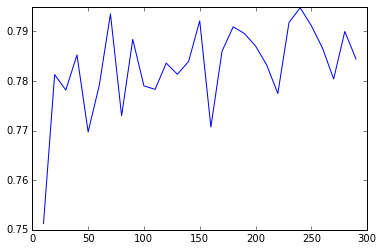

In [32]:
# Making two different groups - TRAINING and HOLDOUT
# TRAINING
conn = sqlite3.connect('/Users/MatthewCohen/Documents/SQLite/TeamSeason1.sqlite')
query = """SELECT t.won as wins, g.good_team, t.o_fgm as field_goals_made, t.o_fga as field_goals_attempted,
t.o_ftm as free_throws_made, t.o_fta as free_throws_attempted, t.o_oreb as offensive_rebounds,
t.o_dreb as defensive_rebounds, t.o_reb as total_rebounds, t.o_asts as assists, t.o_pf as personal_fouls,
t.o_stl as steals, t.o_to as turnovers, t.o_3pm as three_pointers_made, t.o_3pa as three_pointers_attempted,
t.d_fgm as field_goals_allowed, t.d_fga as field_goal_attempts_allowed, t.d_reb as rebounds_allowed,
t.d_asts as assists_allowed, t.d_pf as fouls_against, t.d_3pm as three_point_makes_allowed,
((o_fgm / o_fga)*100) as field_goal_percentage, ((o_ftm / o_fta)*100) as free_throw_percentage,
((o_3pm / o_3pa)*100) as three_point_percentage, o_blk as blocks, o_pts as points, d_pts as points_against
FROM TeamSeason1 t
LEFT OUTER JOIN Good_Teams2 g ON t.team = g.team and t.year = g.year
WHERE t.year > 1980 and t.year < 1999;"""
df = pandas.read_sql(query, conn)
conn.close

# Defining Explanatory Features
#'field_goals_made', 'field_goals_allowed', 'good_team', 'wins', 'points', 'points_against', 'free_throws_made', 'three_pointers_made'
explanatory_features = [col for col in df.columns if col in ['defensive_rebounds', 'assists_allowed', 'field_goal_percentage']]
explanatory_df = df[explanatory_features]
explanatory_colnames = explanatory_df.columns

# Defining Response Series
response_series = df.good_team

# Scaling data such that it is normally distributed in order to input into model and improve accuracy
scaler = preprocessing.StandardScaler()
scaler.fit(explanatory_df)
explanatory_df = pandas.DataFrame(scaler.transform(explanatory_df), columns = explanatory_df.columns)

# Predicting wins using Random Forests 
rf = ensemble.RandomForestClassifier(n_estimators= 500)
roc_scores_rf = cross_val_score(rf, explanatory_df, response_series, cv=10, scoring='roc_auc', n_jobs = -1)

# Grid Search for best parameters
trees_range = range(10, 300, 10)
param_grid = dict(n_estimators = trees_range)
grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc', n_jobs = -1)
grid.fit(explanatory_df, response_series)
grid_mean_scores = [result[1] for result in grid.grid_scores_]
plt.figure()
plt.plot(trees_range, grid_mean_scores)


best_rf_est = grid.best_estimator_


# HOLDOUT
conn = sqlite3.connect('/Users/MatthewCohen/Documents/SQLite/TeamSeason1.sqlite')
query2 = """SELECT t.won as wins, g.good_team, t.o_fgm as field_goals_made, t.o_fga as field_goals_attempted,
t.o_ftm as free_throws_made, t.o_fta as free_throws_attempted, t.o_oreb as offensive_rebounds,
t.o_dreb as defensive_rebounds, t.o_reb as total_rebounds, t.o_asts as assists, t.o_pf as personal_fouls,
t.o_stl as steals, t.o_to as turnovers, t.o_3pm as three_pointers_made, t.o_3pa as three_pointers_attempted,
t.d_fgm as field_goals_allowed, t.d_fga as field_goal_attempts_allowed, t.d_reb as rebounds_allowed,
t.d_asts as assists_allowed, t.d_pf as fouls_against, t.d_3pm as three_point_makes_allowed,
((o_fgm / o_fga)*100) as field_goal_percentage, ((o_ftm / o_fta)*100) as free_throw_percentage,
((o_3pm / o_3pa)*100) as three_point_percentage, o_blk as blocks, o_pts as points, d_pts as points_against
FROM TeamSeason1 t
LEFT OUTER JOIN Good_Teams2 g ON t.team = g.team and t.year = g.year
WHERE t.year >= 1999 and t.year <= 2009;"""
df2 = pandas.read_sql(query2, conn)
conn.close

# Defining Explanatory Features
#'field_goals_made', 'field_goals_allowed', 'good_team', 'wins', 'points', 'points_against"
explanatory_features2 = [col for col in df2.columns if col in ['defensive_rebounds', 'assists_allowed', 'field_goal_percentage']]
explanatory_df2 = df2[explanatory_features2]
explanatory_colnames2 = explanatory_df2.columns

# Defining Response Series
response_series2 = df2.good_team

# Scaling data such that it is normally distributed in order to input into model and improve accuracy
scaler = preprocessing.StandardScaler()
scaler.fit(explanatory_df2)
explanatory_df2 = pandas.DataFrame(scaler.transform(explanatory_df2), columns = explanatory_df2.columns)


prediction = best_rf_est.predict(explanatory_df2)

## Visualize Results

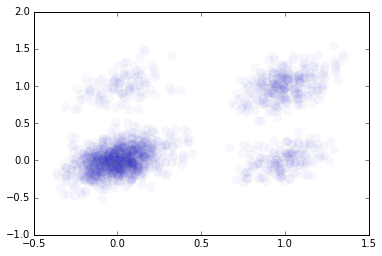

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

y = response_series2.tolist()
yhat = prediction.tolist()

def randomize(mean):
    N = 5
    cov = [[0.02, 0.02], [0, 0.02]]
    x,y = np.random.multivariate_normal(mean, cov, N).T
    plt.scatter(x, y, s=70, alpha=0.03)
#    return x,y

for i in range(1,325):
    randomize((y[i], yhat[i]))
 #   plt.scatter(x, y, s=70, alpha=0.03)

## Accuracy

In [35]:
diff = (response_series2 - prediction).tolist()
accuracy = (diff.count(0)/len(diff))*100
print accuracy

0
